In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime
import pytz

import quandl

import seaborn as sns

import sys

In [247]:
def port_eval(port, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    Max_Daily_Drawdown = Max_Daily_Drawdown.tail(1)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    
    if freq == 'D':
        cagr = port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1
        MAR = cagr/Max_Daily_Drawdown
        vol = np.log(port_ret).std()*np.sqrt(252)
        sortino = np.log(neg_ret).std()*np.sqrt(252)
        sharpe = cagr/vol
        
    elif freq == 'M':
        cagr = port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1
        MAR = cagr/Max_Daily_Drawdown
        vol = np.log(port_ret).std()*np.sqrt(12)
        sortino = np.log(neg_ret).std()*np.sqrt(12)
        sharpe = cagr/vol
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]*100), float(sortino.iloc[0]*100),
                                 float(sharpe.iloc[0]),float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0]))]},
                   index=['CAGR', 'Volatility', 'Sortino','Sharpe', 'Max DD', 'MAR'])
    
    metrics = round(metrics, 2)
    #metrics = metrics.astype(str) + '%'
    
    return metrics 

In [248]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [249]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if sum(W) == 1:

        for i in range(len(data)):
            port.append(initial)
            port_W.append([i / initial for i in asset])
        
            asset = asset * data.iloc[i]
            initial = sum(asset)
        
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result)
        
    else:
        print("Weight not Equal to 1!")

In [250]:
def strategy_evaluation(result, data_names, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR' ],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Sortino', ],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}"})
      .set_table_styles(styles))
    
    return metrics

# Backtesting Portfolio

TODO:
- 

In [5]:
asset_1_tmp = yf.download("^GSPC")
#asset_2_tmp = yf.download("^VIX")
asset_3_tmp = yf.download("SHY")
asset_4_tmp =  yf.download("TLT")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
asset_2_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")

In [7]:
data_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

In [21]:
asset_1 = asset_1_tmp['Close']
asset_2 = asset_2_tmp["USD (AM)"]
asset_3 = asset_3_tmp['Close']
asset_4 = asset_4_tmp['Close']

In [256]:
data = pd.concat([asset_1], axis = 1) #asset_2, asset_4
data = data.ffill()
data = data.dropna()
data = data/data.shift(1)
data = data.fillna(1)

data_names = ['SPY'] #,'Gold' ,'Bonds'
data.columns = data_names

In [258]:
data = pd.concat([asset_1], axis = 1)
data = data.ffill()
data = data.dropna()
monthly_data = data.resample('M').first()
monthly_data.index=monthly_data.index.map(lambda x : x.replace(day=1))

long_vol = data_imp[3:]
long_vol.index= pd.to_datetime(data_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])


monthly_data = pd.concat([monthly_data, long_vol], axis=1)
monthly_data = monthly_data.ffill()
monthly_data = monthly_data.dropna()
monthly_data.columns = data_names + ["Long Vol"]
monthly_data = monthly_data/monthly_data.shift()
monthly_data = monthly_data.fillna(1)

In [261]:
rebalance_freq = 6
tol = 0.10
W = [0.5, 0.5]

data_names = ['SPY'] + ["Long Vol"]


result = backtest_strategy(monthly_data, W, tol, rebalance_freq, data_names)

,CAGR,Volatility,Sortino,Sharpe,Max DD,MAR
Portfolio,6.0%,8.91,7.25,0.72,-18.0%,0.35
SPY,6.0%,17.45,16.23,0.36,-55.0%,0.12
Long Vol,5.0%,8.09,2.96,0.62,-29.0%,0.17


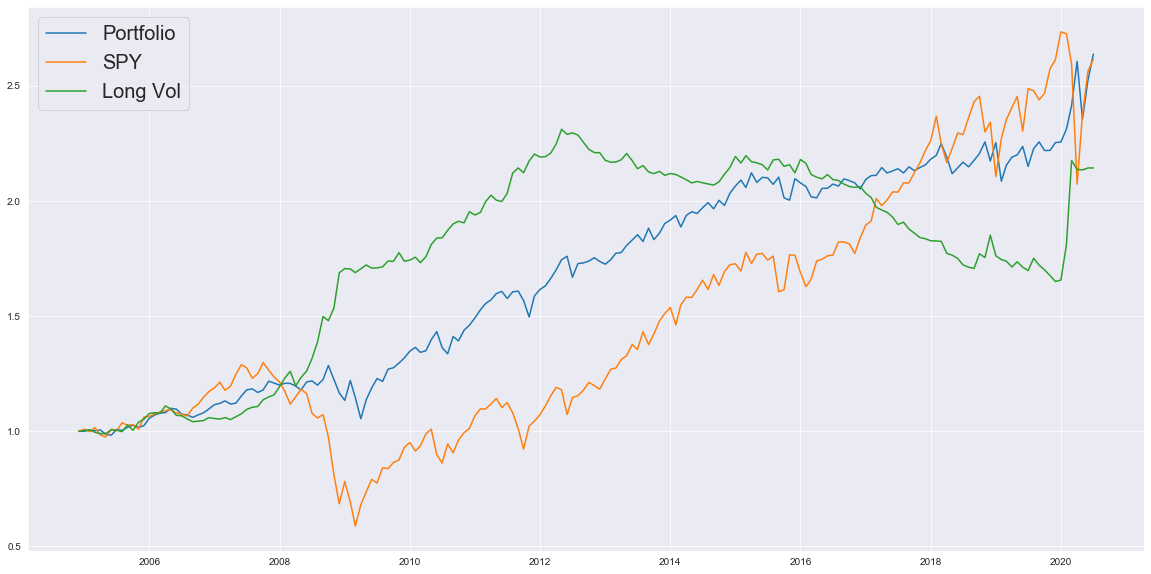

In [262]:
sns.set_style("darkgrid")
plt.figure(figsize=(20,10))
for i in result.columns:
    plt.plot(result[i], label = i);

plt.legend(loc=2, prop={'size': 20});

strategy_evaluation(result, data_names, freq = 'M')